# CNN
Laden des auf Hybrid_Datensatz trainierten Modells  
Test auf hybrid_b17_test (= 90% Benign IDS17 + 100% non-BENIGN IDS17)

In [ ]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import joblib
from sklearn.metrics import classification_report, confusion_matrix


2024-11-01 19:32:29.176467: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 19:32:29.277277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 19:32:29.317705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 19:32:29.328775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 19:32:29.395277: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [3]:
!nvidia-smi

Fri Nov  1 19:32:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             N/A /  115W |    1389MiB /   8188MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Laden von hybrid_b17_test

In [ ]:
hybrid_b17_test = pd.read_parquet('../01_Datensaetze/improved_hybrid_b17/hybrid_b17_test.parquet')
logging.info("Class distribution\n{}".format(hybrid_b17_test.Label.value_counts()))

2024-11-01 19:32:31 - INFO - Class distribution
Label
DoS Hulk                        158468
BENIGN                          158257
DDoS-LOIC-HTTP                   95144
Infiltration - NMAP Portscan     71767
DoS GoldenEye                     7567
DoS Slowloris                     3859
SSH-BruteForce                    2961
Botnet Ares                        736
Web Attack - Brute Force            73
Web Attack - XSS                    18
Web Attack - SQL                    13
Name: count, dtype: int64


In [ ]:
logging.info(hybrid_b17_test.shape)
logging.info(hybrid_b17_test.columns)

2024-11-01 19:32:31 - INFO - (498863, 84)
2024-11-01 19:32:31 - INFO - Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Pack

### Trennen von Features und Labels

In [ ]:
X = hybrid_b17_test.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = hybrid_b17_test.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (498863, 83)
Form von y: (498863,)


### Label Encoding für y

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [ ]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.fit_transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (498863, 83)
Form von X_scaled: (498863, 83)


### Umformen der Daten für das CNN

In [11]:
# Anzahl der Features
num_features = X_scaled.shape[1]  # Sollte 83 sein

# Umformen zu (Anzahl_Beispiele, num_features, 1)
X_reshaped = X_scaled.reshape(-1, num_features, 1)
print("Form von X_reshaped:", X_reshaped.shape)  # Erwartet: (1923167, 83, 1)

Form von X_reshaped: (498863, 83, 1)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [12]:
X_test, y_test = X_reshaped, y_encoded
X_test.shape, y_test.shape

((498863, 83, 1), (498863,))

### Überprüfen der Klassenverteilung

In [13]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 158257 Beispiele (31.72%)
  Klasse 1: 736 Beispiele (0.15%)
  Klasse 2: 95144 Beispiele (19.07%)
  Klasse 3: 7567 Beispiele (1.52%)
  Klasse 4: 158468 Beispiele (31.77%)
  Klasse 5: 3859 Beispiele (0.77%)
  Klasse 6: 71767 Beispiele (14.39%)
  Klasse 7: 2961 Beispiele (0.59%)
  Klasse 8: 73 Beispiele (0.01%)
  Klasse 9: 13 Beispiele (0.00%)
  Klasse 10: 18 Beispiele (0.00%)



### Laden des Modells

In [14]:
# from tensorflow import keras
# import joblib

# Laden des Modells
cnn_model = keras.models.load_model('hybrid_cnn_model.h5')

# Laden des Label Encoders und Scalers
# label_encoder = joblib.load('label_encoder.pkl')
# scaler = joblib.load('scaler.pkl')

I0000 00:00:1730485951.936962  958518 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730485952.012522  958518 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730485952.012567  958518 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730485952.014917  958518 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730485952.014955  958518 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Evaluierung des Modells auf dem Testdatensatz

In [15]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")

I0000 00:00:1730485952.969146  959108 service.cc:146] XLA service 0x7fe230006030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730485952.969172  959108 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-01 19:32:32.981524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-01 19:32:33.017510: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  191/15590 ━━━━━━━━━━━━━━━━━━━━ 12s 794us/step - loss: 25.8402 - sparse_categorical_accuracy: 0.4431  

I0000 00:00:1730485953.509689  959108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15590/15590 ━━━━━━━━━━━━━━━━━━━━ 14s 864us/step - loss: 26.1330 - sparse_categorical_accuracy: 0.4392
Testverlust: 26.1137
Testgenauigkeit: 0.4399


### Klassifikationsbericht und eine Konfusionsmatrix

In [16]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Konfusionsmatrix:")
print(cm)

15590/15590 ━━━━━━━━━━━━━━━━━━━━ 11s 716us/step


/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       0.36      1.00      0.53    158257
                 Botnet Ares       0.89      0.97      0.93       736
              DDoS-LOIC-HTTP       1.00      0.00      0.00     95144
               DoS GoldenEye       0.97      0.13      0.23      7567
                    DoS Hulk       0.00      0.00      0.00    158468
               DoS Slowloris       0.99      0.91      0.95      3859
Infiltration - NMAP Portscan       0.99      0.79      0.88     71767
              SSH-BruteForce       0.00      0.00      0.00      2961
    Web Attack - Brute Force       0.00      0.00      0.00        73
            Web Attack - SQL       0.00      0.00      0.00        13
            Web Attack - XSS       0.00      0.00      0.00        18

                    accuracy                           0.44    498863
                   macro avg       0.47      0.34      0.32    498863
                we

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualisierung der Konfusionsmatrix

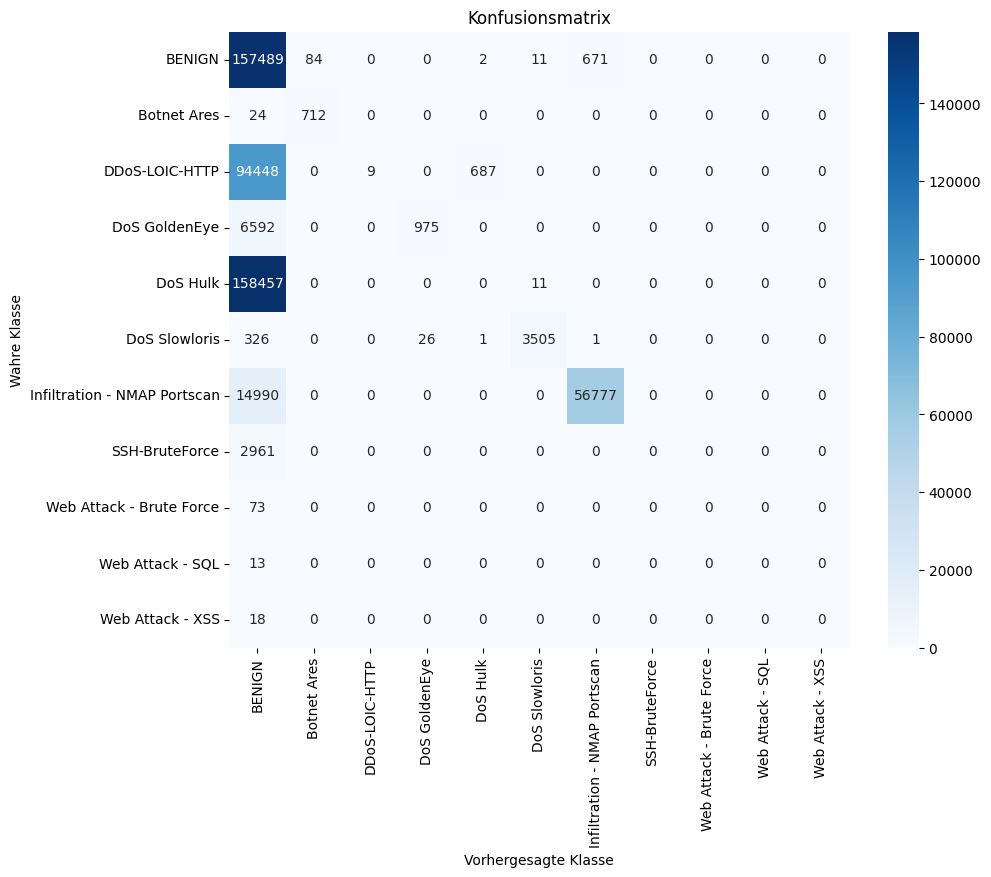

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
